In [37]:
import os, re 
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### 데이터셋 불러오기

In [1]:


txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path) 

raw_corpus = [] 

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw) 

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])


데이터 크기: 187088
Examples:
 ["Busted flat in Baton Rouge, waitin' for a train", "And I's feelin' near as faded as my jeans", 'Bobby thumbed a diesel down, just before it rained']


### 전처리 : 문장 다듬기   
문장에서 특수문자를 제거, 대문자를 소문자로 일괄 변환한 후,  
각 문장이 토큰화 되었을 때 인식될 <start> <end> 토큰을 앞뒤로 붙여줍니다

In [2]:
# preprocess_sentence() 만들기

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence


In [3]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠

corpus[:10]

['<start> busted flat in baton rouge , waitin for a train <end>',
 '<start> and i s feelin near as faded as my jeans <end>',
 '<start> bobby thumbed a diesel down , just before it rained <end>',
 '<start> it rode us all the way to new orleans i pulled my harpoon out of my dirty red bandanna <end>',
 '<start> i was playin soft while bobby sang the blues , yeah <end>',
 '<start> windshield wipers slappin time , i was holdin bobby s hand in mine <end>',
 '<start> we sang every song that driver knew freedom s just another word for nothin left to lose <end>',
 '<start> nothin , don t mean nothin hon if it ain t free , no no <end>',
 '<start> and , feelin good was easy , lord , when he sang the blues <end>',
 '<start> you know , feelin good was good enough for me <end>']

### 전처리 : 토큰화  
각 문장의 단어를 텐서형태의 표현으로 바꿉니다  
단어는 이제 자신과 서로의 관계를 수리적으로 표현한 벡터 형태가 되었습니다  

In [4]:
def tokenize(corpus):

    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor,tokenizer)
    return tensor, tokenizer



In [5]:
tensor, tokenizer = tokenize(corpus)

[[   2 3604 1691 ...    0    0    0]
 [   2    8    5 ...    0    0    0]
 [   2  804 7655 ...    0    0    0]
 ...
 [   2    5   22 ...    0    0    0]
 [   2    5   22 ...    0    0    0]
 [   2    5   22 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f83440ecd00>


In [6]:
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

src_input.shape

[   2 3604 1691   14 7050 3995    4 1100   28    9  681    3    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

(175749, 346)

### 모델 생성 : 준비  
모델 생성에 필요한 하이퍼파라메터를 정의합니다  
배치사이즈와 버퍼사이즈가 Resource Exhausted error를 일으키지 않도록 너무 높은 값을 가지지 않도록 합니다  

In [7]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 128
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((128, 346), (128, 346)), types: (tf.int32, tf.int32)>

In [8]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   


In [9]:
embedding_size = 128 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 256 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.


In [38]:
# train / test split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=34)


In [11]:
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)



<tf.Tensor: shape=(128, 346, 12001), dtype=float32, numpy=
array([[[ 1.77224647e-04, -7.96934764e-05,  5.81025488e-05, ...,
         -7.57827656e-05, -3.37975980e-05,  1.47880230e-04],
        [ 3.91871086e-04, -9.76367155e-05,  5.33230195e-05, ...,
         -7.65762816e-05, -8.87148490e-05,  2.34910651e-04],
        [ 5.53590246e-04, -3.53733485e-05, -2.40752197e-05, ...,
         -1.26604587e-04, -2.51183024e-04,  1.15398951e-04],
        ...,
        [ 2.14654929e-03, -2.49136798e-03, -4.88034886e-04, ...,
          1.23794319e-03,  1.23105722e-03,  1.48540747e-03],
        [ 2.14654929e-03, -2.49136775e-03, -4.88034886e-04, ...,
          1.23794307e-03,  1.23105734e-03,  1.48540747e-03],
        [ 2.14654929e-03, -2.49136775e-03, -4.88034770e-04, ...,
          1.23794319e-03,  1.23105722e-03,  1.48540747e-03]],

       [[ 1.77224647e-04, -7.96934764e-05,  5.81025488e-05, ...,
         -7.57827656e-05, -3.37975980e-05,  1.47880230e-04],
        [ 4.23337246e-04, -1.32090237e-04,  

In [12]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1536128   
_________________________________________________________________
lstm (LSTM)                  multiple                  394240    
_________________________________________________________________
lstm_1 (LSTM)                multiple                  525312    
_________________________________________________________________
dense (Dense)                multiple                  3084257   
Total params: 5,539,937
Trainable params: 5,539,937
Non-trainable params: 0
_________________________________________________________________


In [13]:
optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.

In [18]:
import tqdm
import tensorflow_addons as tfa

tqdm_callback = tfa.callbacks.TQDMProgressBar()

history = model.fit(dataset, epochs=10) 

Epoch 1/10
1373/1373 [==============================] - 635s 462ms/step - loss: 0.1506
Epoch 2/10
1373/1373 [==============================] - 639s 465ms/step - loss: 0.1397
Epoch 3/10
1373/1373 [==============================] - 642s 468ms/step - loss: 0.1363
Epoch 4/10
1373/1373 [==============================] - 642s 467ms/step - loss: 0.1305
Epoch 5/10
1373/1373 [==============================] - 642s 467ms/step - loss: 0.1262
Epoch 6/10
1373/1373 [==============================] - 640s 466ms/step - loss: 0.1220
Epoch 7/10
1373/1373 [==============================] - 642s 467ms/step - loss: 0.1182
Epoch 8/10
1373/1373 [==============================] - 638s 465ms/step - loss: 0.1146
Epoch 9/10
1373/1373 [==============================] - 641s 467ms/step - loss: 0.1114
Epoch 10/10
1373/1373 [==============================] - 637s 464ms/step - loss: 0.1084


In [39]:
history.history

{'loss': [0.15061014890670776,
  0.1396825611591339,
  0.13631729781627655,
  0.13048508763313293,
  0.12620870769023895,
  0.12204638123512268,
  0.1181749477982521,
  0.11462534219026566,
  0.11135441809892654,
  0.10837319493293762]}

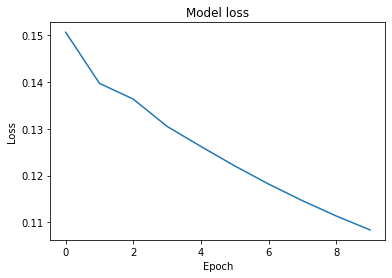

In [42]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

첫 배치부터 loss가 낮았습니다  


In [19]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

       while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

In [24]:
generate_text(model, tokenizer, init_sentence="<start> I love") 

'<start> i love you , i love you , i love you , i love '

### 문장이 정상적이지 않습니다

### Validation set을 20% 사용하여, 새로 학습을 진행해보겠습니다

In [26]:
model_2 = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [27]:
model_2(src_sample)

<tf.Tensor: shape=(128, 346, 12001), dtype=float32, numpy=
array([[[ 9.46491346e-05, -1.38631949e-04,  1.19075245e-04, ...,
          5.91514945e-05, -2.16002984e-04, -1.00066150e-04],
        [-5.52567108e-05, -1.28187776e-05,  1.96226989e-04, ...,
          7.75524240e-05, -2.59345805e-04, -2.92766170e-04],
        [ 3.10206838e-06, -4.90493439e-05,  1.12792863e-04, ...,
         -5.26553486e-05, -2.18496643e-04, -3.63681407e-04],
        ...,
        [ 1.60614075e-03, -1.41605531e-04, -1.52206083e-03, ...,
          2.00212328e-03,  1.60102220e-03, -4.41792276e-04],
        [ 1.60614098e-03, -1.41605517e-04, -1.52206083e-03, ...,
          2.00212281e-03,  1.60102220e-03, -4.41792043e-04],
        [ 1.60614145e-03, -1.41605546e-04, -1.52206072e-03, ...,
          2.00212281e-03,  1.60102232e-03, -4.41792159e-04]],

       [[ 9.46491346e-05, -1.38631949e-04,  1.19075245e-04, ...,
          5.91514945e-05, -2.16002984e-04, -1.00066150e-04],
        [ 3.20699146e-05,  8.39137865e-05,  

In [28]:
model_2.summary()

Model: "text_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  1536128   
_________________________________________________________________
lstm_4 (LSTM)                multiple                  394240    
_________________________________________________________________
lstm_5 (LSTM)                multiple                  525312    
_________________________________________________________________
dense_2 (Dense)              multiple                  3084257   
Total params: 5,539,937
Trainable params: 5,539,937
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_2.compile(loss=loss, optimizer=optimizer)

In [33]:
tqdm_callback2 = tfa.callbacks.TQDMProgressBar()

history2 = model.fit(enc_train, dec_train, epochs=10, batch_size=BATCH_SIZE, validation_data=(enc_val, dec_val))

Epoch 1/10
1099/1099 [==============================] - 608s 552ms/step - loss: 0.1057 - val_loss: 0.1058
Epoch 2/10
1099/1099 [==============================] - 606s 552ms/step - loss: 0.1031 - val_loss: 0.1058
Epoch 3/10
1099/1099 [==============================] - 607s 552ms/step - loss: 0.1008 - val_loss: 0.1058
Epoch 4/10
1099/1099 [==============================] - 606s 551ms/step - loss: 0.0986 - val_loss: 0.1057
Epoch 5/10
1099/1099 [==============================] - 603s 549ms/step - loss: 0.0966 - val_loss: 0.1057
Epoch 6/10
1099/1099 [==============================] - 605s 550ms/step - loss: 0.0947 - val_loss: 0.1058
Epoch 7/10
1099/1099 [==============================] - 607s 552ms/step - loss: 0.0928 - val_loss: 0.1057
Epoch 8/10
1099/1099 [==============================] - 605s 550ms/step - loss: 0.0911 - val_loss: 0.1058
Epoch 9/10
1099/1099 [==============================] - 603s 549ms/step - loss: 0.0895 - val_loss: 0.1060
Epoch 10/10
1099/1099 [=======================

In [43]:
history2.history

{'loss': [0.10570963472127914,
  0.10310664772987366,
  0.10079552233219147,
  0.09862092137336731,
  0.09658581018447876,
  0.09465497732162476,
  0.09281924366950989,
  0.09110462665557861,
  0.08945996314287186,
  0.0878962054848671],
 'val_loss': [0.10579028725624084,
  0.10581045597791672,
  0.10580892115831375,
  0.10568706691265106,
  0.10570049285888672,
  0.10576296597719193,
  0.1056777760386467,
  0.10583018511533737,
  0.10601022094488144,
  0.10617338865995407]}

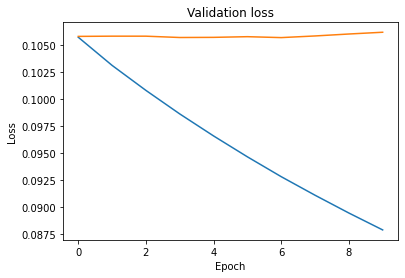

In [45]:
plt.plot(history2.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.plot(history2.history['val_loss'])
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [34]:
generate_text(model_2, tokenizer, init_sentence="<start> I love")

'<start> i love happenin happenin imagination imagination salsa borin guided diamonds diamonds borin borin destination '

## 회고   
Rnn 신경망에서 Validation set 을 사용하여 hyperparameter값을 조정함으로써 출력물이 바뀜을 확인할 수 있었습니다   
하지만 train / test 과정에서 일반적인 loss / validation loss의 변화추이를 확인할 수 없었습니다  
또한 문장의 단어도 validation 을 사용했을 때, 변화를 확인했지만 문장이 자연스럽지 않았습니다  
train / test 과정에서 제대로 된 작업을 수행하지 못했음이 의심됩니다  
  
epoch나 다른 hyperparamete의 값의 변화에 따라 성능이 어떻게 바뀌는지 추후 확인하여, 바른 결과를 낼 수 있도록 수정하겠습니다  